## Veriyi Anlamak

In [253]:
# Gerekli Olan Kütüphaneler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [254]:
df = pd.read_csv("TSLA.csv")

In [255]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [256]:
df["Date"]=pd.to_datetime(df["Date"])

In [257]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [258]:
tesla_df = df[["Date","Close"]]

In [259]:
tesla_df

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
...,...,...
2411,2020-01-28,566.900024
2412,2020-01-29,580.989990
2413,2020-01-30,640.809998
2414,2020-01-31,650.570007


In [260]:
tesla_df.index =tesla_df["Date"]

In [261]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [262]:
tesla_df.drop("Date",axis=1,inplace=True)

In [263]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [264]:
result_df = tesla_df.copy()

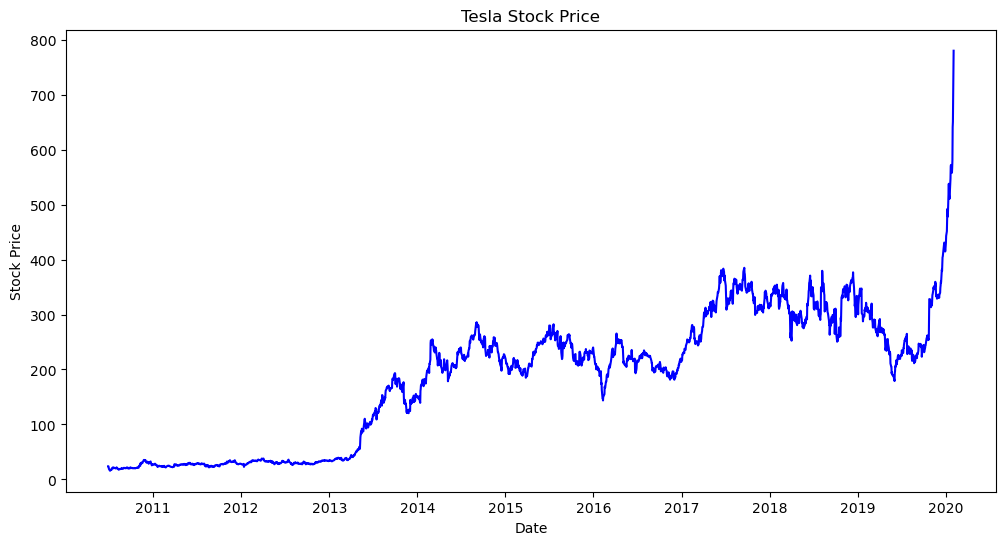

In [265]:
plt.figure(figsize=(12,6))
plt.plot(result_df["Close"],color="blue")
plt.ylabel("Stock Price")
plt.xlabel("Date")
plt.title("Tesla Stock Price")
plt.show()

In [266]:
tesla_df = tesla_df.values

In [267]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [268]:
tesla_df = tesla_df.astype("float32")

In [269]:
# Train-Test Ayrımının yapılması

In [270]:
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe)*test_size)*(1-test_size))
    train, test = dataframe[:pos], dataframe[pos:]
    return train, test, pos

In [271]:
train, test, pos = split_data(tesla_df,0.20)

In [272]:
print(train.shape, test.shape)

(386, 1) (2030, 1)


In [273]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [274]:
train = scaler_train.fit_transform(train)

In [275]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [276]:
test = scaler_test.fit_transform(test)

In [277]:
def create_features(data, lockback):
    x,y = [],[]
    for i in range(lockback,len(data)):
        x.append(data[i-lookback:i,0])
        y.append(data[i,0])
    return np.array(x),np.array(y)

In [278]:
lookback = 20

In [279]:
# Traib Veri Seti 
x_train,y_train = create_features(train,lookback)
x_test, y_test = create_features(test,lookback)

In [280]:
x_train

array([[0.41128618, 0.40823585, 0.31316715, ..., 0.27910525, 0.26182002,
        0.24148446],
       [0.40823585, 0.31316715, 0.1728521 , ..., 0.26182002, 0.24148446,
        0.25012702],
       [0.31316715, 0.1728521 , 0.01576006, ..., 0.24148446, 0.25012702,
        0.23131675],
       ...,
       [0.9466191 , 0.96949655, 0.9349261 , ..., 0.6573462 , 0.6487035 ,
        0.6243009 ],
       [0.96949655, 0.9349261 , 0.767158  , ..., 0.6487035 , 0.6243009 ,
        0.6054905 ],
       [0.9349261 , 0.767158  , 0.7747839 , ..., 0.6243009 , 0.6054905 ,
        0.57549566]], dtype=float32)

In [281]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(366, 20) (366,) (2010, 20) (2010,)


In [282]:
x_train = np.reshape(x_train, (x_train.shape[0],1,x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0],1,x_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [283]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(366, 1, 20) (366, 1) (2010, 1, 20) (2010, 1)


## Modelleme

In [284]:
model = Sequential()

In [285]:
model.add(LSTM(units=50, activation="relu", input_shape=(x_train.shape[1],lookback)))

In [286]:
model.add(Dropout(0.2))
model.add(Dense(1))

In [287]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50)                14200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [288]:
# Optimziyon ve Değerlendirme Metriklerinin Ayarlanması

In [289]:
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [290]:
callbacks = [EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",save_best_only=True, save_weights_only=False, verbose=1)]

In [291]:
history = model.fit(x=x_train,
                    y= y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(x_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
 1/19 [>.............................] - ETA: 27s - loss: 0.0401
Epoch 1: val_loss improved from inf to 0.01726, saving model to mymodel.h5
19/19 [==============================] - 2s 19ms/step - loss: 0.1481 - val_loss: 0.0173
Epoch 2/100
 1/19 [>.............................] - ETA: 0s - loss: 0.0084
Epoch 2: val_loss improved from 0.01726 to 0.00146, saving model to mymodel.h5
19/19 [==============================] - 0s 8ms/step - loss: 0.0324 - val_loss: 0.0015
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 0.0063
Epoch 3: val_loss improved from 0.00146 to 0.00113, saving model to mymodel.h5
19/19 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 0.0011
Epoch 4/100
 1/19 [>.............................] - ETA: 0s - loss: 0.0082
Epoch 4: val_loss did not improve from 0.00113
19/19 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.0017
Epoch 5/100
 1/19 [>.............................] - ETA: 0s - los

## Değerlendirme

In [292]:
loss = model.evaluate(x_test, y_test, batch_size=20)
print("\nTest Loss: %.1f%%" % (100.0*loss))

101/101 [==============================] - 0s 745us/step - loss: 0.0014

Test Loss: 0.1%


In [293]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

63/63 [==============================] - 0s 676us/step


In [294]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [295]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [296]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [297]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [298]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 2.1872940063476562
Test RMSE: 27.853851318359375


In [299]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,2416,2015-04-15 11:09:56.026490112,2010-06-29 00:00:00,2012-11-19 18:00:00,2015-04-16 12:00:00,2017-09-07 06:00:00,2020-02-03 00:00:00,NaN
Open,2416.0,186.271147,16.139999,34.342498,213.035004,266.450012,673.690002,118.740163
High,2416.0,189.578224,16.629999,34.897501,216.745002,270.927513,786.140015,120.892329
Low,2416.0,182.916639,14.98,33.587501,208.870002,262.102501,673.52002,116.857591
Close,2416.0,186.403651,15.8,34.400002,212.960007,266.774994,780.0,119.13602
Adj Close,2416.0,186.403651,15.8,34.400002,212.960007,266.774994,780.0,119.13602
Volume,2416.0,5572721.688742,118500.0,1899275.0,4578400.0,7361150.0,47065000.0,4987809.151888


In [303]:
train_prediction_df = result_df[lookback:pos]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,19.984259
2010-07-29,20.350000,19.991297
2010-07-30,19.940001,19.960081
2010-08-02,20.920000,19.989937
2010-08-03,21.950001,20.092108
